In [17]:
import feather
import scipy as sp
import numpy as np
import pandas as pd
import lightgbm as lgb

from collections import Counter
from functools import partial
from math import sqrt
from scipy.stats import rankdata
from pdpbox import pdp

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.model_selection import StratifiedKFold, GroupKFold

import matplotlib.pyplot as plt
import seaborn as sns

target = 'AdoptionSpeed'
len_train = 14993
len_test = 3948
    
    
# ===============
# Params
# ===============
seed = 777
n_splits = 5
np.random.seed(seed)

# feature engineering
n_components = 5
img_size = 256
batch_size = 256

# model
MODEL_PARAMS = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'subsample': 0.9,
    'subsample_freq': 1,
    #'colsample_bytree': 0.6,
    'max_depth': 9,
    'max_bin': 127,
    'reg_alpha': 0.11,
    'reg_lambda': 0.01,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split': 0.02,
    'min_data_in_bin': 3,
    'bin_construct_sample_cnt': 5000,
    'cat_l2': 10,
    'verbose': -1,
    'nthread': 16,
    'seed': 777,
}
FIT_PARAMS = {
    'num_boost_round': 5000,
    'early_stopping_rounds': 100,
    'verbose_eval': 10000,
}

# define
maxvalue_dict = {}
categorical_features = [
     'Breed1',
     'Breed2',
     'Color1',
     'Color2',
     'Color3',
     'Dewormed',
     'FurLength',
     'Gender',
     'Health',
     'MaturitySize',
     'State',
     'Sterilized',
     'Type',
     'Vaccinated',
     'Type_main_breed',
     'BreedName_main_breed',
     'Type_second_breed',
     'BreedName_second_breed',
]
numerical_features = []
text_features = ['Name', 'Description']
remove = ['index', 'seq_text', 'PetID', 'Name', 'Description', 'RescuerID', 'StateName', 'annots_top_desc','sentiment_text', 
          'Description_Emb', 'Description_bow', 'annots_top_desc_pick']

def get_score(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def get_y():
    return pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv', usecols=[target]).values.flatten()
    
def run_model(X_train, y_train, X_valid, y_valid,
            categorical_features, numerical_features,
            predictors, maxvalue_dict, fold_id):
    train = lgb.Dataset(X_train, y_train, 
                        categorical_feature=categorical_features, 
                        feature_name=predictors)
    valid = lgb.Dataset(X_valid, y_valid, 
                        categorical_feature=categorical_features, 
                        feature_name=predictors)
    evals_result = {}
    model = lgb.train(
        MODEL_PARAMS,
        train,
        valid_sets=[valid],
        valid_names=['valid'],
        evals_result=evals_result,
        **FIT_PARAMS
    )
    
    # validation score
    y_pred_valid = model.predict(X_valid)

    # feature importances
    importances = pd.DataFrame()
    importances['feature'] = predictors
    importances['gain'] = model.feature_importance(importance_type='gain')
    importances['split'] = model.feature_importance(importance_type='split')
    importances['fold'] = fold_id

    return y_pred_valid, importances, model
 
def plot_mean_feature_importances(feature_importances, max_num=50, importance_type='gain', path=None):
    mean_gain = feature_importances[[importance_type, 'feature']].groupby('feature').mean()
    feature_importances['mean_' + importance_type] = feature_importances['feature'].map(mean_gain[importance_type])

    if path is not None:
        data = feature_importances.sort_values('mean_'+importance_type, ascending=False).iloc[:max_num, :]
        plt.clf()
        plt.figure(figsize=(16, 8))
        sns.barplot(x=importance_type, y='feature', data=data)
        plt.tight_layout()
        plt.savefig(path)
    
    return feature_importances

def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class OptimizedRounder_(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -get_score(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -get_score(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [0.2, 0.4, 0.6, 0.8]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(0.01, 0.3), (0.15, 0.56), (0.35, 0.75), (0.6, 0.9)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
class StratifiedGroupKFold():
    def __init__(self, n_splits=5):
        self.n_splits = n_splits
    
    def split(self, X, y=None, groups=None):
        fold = pd.DataFrame([X, y, groups]).T
        fold.columns = ['X', 'y', 'groups']
        fold['y'] = fold['y'].astype(int)
        g = fold.groupby('groups')['y'].agg('mean').reset_index()
        fold = fold.merge(g, how='left', on='groups', suffixes=('', '_mean'))
        fold['y_mean'] = fold['y_mean'].apply(np.round)
        fold['fold_id'] = 0
        for unique_y in fold['y_mean'].unique():
            mask = fold.y_mean==unique_y
            selected = fold[mask].reset_index(drop=True)
            cv = GroupKFold(n_splits=n_splits)
            for i, (train_index, valid_index) in enumerate(cv.split(range(len(selected)), y=None, groups=selected['groups'])):
                selected.loc[valid_index, 'fold_id'] = i
            fold.loc[mask, 'fold_id'] = selected['fold_id'].values
            
        for i in range(self.n_splits):
            indices = np.arange(len(fold))
            train_index = indices[fold['fold_id'] != i]
            valid_index = indices[fold['fold_id'] == i]
            yield train_index, valid_index
            
def merge(train, path, add_cols):
    df_ = feather.read_dataframe(path)
    add_cols += list(df_.columns)
    train = pd.concat((train, df_[:len_train]), axis=1)
    return train, add_cols

In [8]:
train = feather.read_dataframe('all_data.feather')
train = train[:len_train].reset_index(drop=True)
add_cols = []

1000
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[966]	valid's rmse: 1.02555
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[788]	valid's rmse: 1.03814
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[850]	valid's rmse: 1.0318
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1096]	valid's rmse: 1.03457
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[905]	valid's rmse: 1.05254
0.4556117063966877
CPU times: user 1h 51min 30s, sys: 1h 8min 46s, total: 3h 16s
Wall time: 24min 19s


<Figure size 432x288 with 0 Axes>

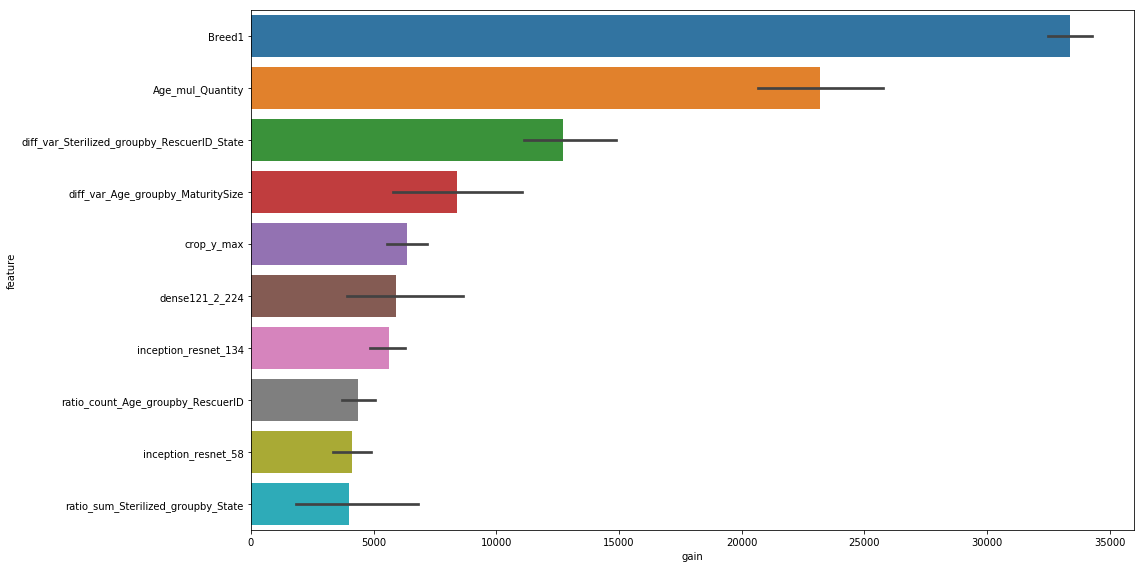

In [24]:
%%time
#n_feats =2024
#predictors = list(data.feature[:n_feats])
use_cols = pd.read_csv("importance10.csv")
predictors = list(use_cols.feature[:1000])
print(len(predictors))
categorical_features = [c for c in categorical_features if c in predictors]
numerical_features = list(set(predictors) - set(categorical_features + [target] + remove))
#predictors = categorical_features + numerical_features

X = train.loc[:, predictors]
y =  feather.read_dataframe('../input/X_train.feather')["AdoptionSpeed"].values
rescuer_id = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv').loc[:, 'RescuerID'].iloc[:len_train]

feature_importances = pd.DataFrame()
y_pred = np.empty(len_train,)
y_test = []
pdp_dic = {}

cv = GroupKFold(n_splits=n_splits)
for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y=None, groups=rescuer_id)): 
    X_train = X.loc[train_index, :]
    X_valid = X.loc[valid_index, :]
    y_train = y[train_index]
    y_valid = y[valid_index]

    y_pred_valid, importances, model = run_model(X_train, y_train, X_valid, y_valid,
                     categorical_features, numerical_features,
                     predictors, maxvalue_dict, fold_id)
    y_pred_valid = rankdata(y_pred_valid)/len(y_pred_valid)
    y_pred[valid_index] = y_pred_valid.ravel()

    feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)
    
    for feature_to_plot in predictors[:20]:
        n_bins = 30 if X[feature_to_plot].nunique() > 30 else X[feature_to_plot].nunique()-1
        sr_cut, bins = pd.qcut(X[feature_to_plot].dropna(), n_bins, retbins=True, duplicates='drop')
        pdp_feats = pdp.pdp_isolate(
                    model=model,
                    dataset=pd.DataFrame(X_valid, columns=predictors),
                    model_features=predictors,
                    feature=feature_to_plot,
                    #num_grid_points=10,
                    cust_grid_points=bins
                )
        ice_lines = pdp_feats.ice_lines
        feature_grids = pdp_feats.feature_grids
        if fold_id == 0:
            pdp_dic[feature_to_plot] = {
                "feature": feature_to_plot,
                "x": list(feature_grids),
                "y": np.zeros(len(feature_grids)),
                "std": np.zeros(len(feature_grids)),
            }
        pdp_dic[feature_to_plot]["y"] += pdp_feats.pdp / n_splits
        pdp_dic[feature_to_plot]["std"] += ice_lines[feature_grids].std().values / n_splits

# plot
feature_importances = plot_mean_feature_importances(
                            feature_importances, 
                            max_num=50, 
                            importance_type='gain', 
                            path='gain_feature_importances.png')

optR = OptimizedRounder()
optR.fit(y_pred, y)
coefficients = optR.coefficients()
y_pred_opt = optR.predict(y_pred, coefficients)
score = get_score(y, y_pred_opt)
print(score)

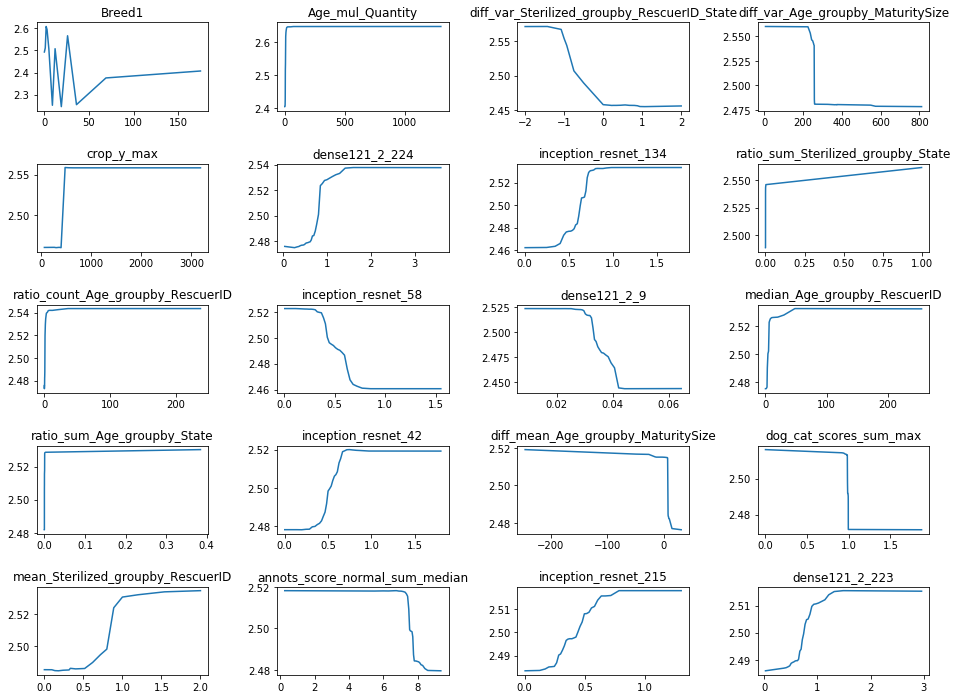

In [26]:
plt.figure(figsize=(16, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for i, (keys, values) in enumerate(pdp_dic.items()):
    plt.subplot(5, 4, i+1)
    plt.title(keys)
    plt.plot(values["x"], values["y"])
plt.savefig("pdp.jpg")